# Validação de CPFs - Experimento de validação paralelizada com Dask

https://colab.research.google.com/drive/1T7aMBFqOSsbB7BWPtmJZScO9o3CaUc_y?usp=sharing

# Preparo dos dados

## Geração de números aleatórios

In [1]:
import numpy as np

In [2]:
# Geração de números inteiros com até 9 dígitos
# para posterior cálculo de DV usando algoritmo
# de validação de CPFs
np.random.seed(42)

# quantidade de números a serem gerados
#num_amostras = 200
#num_amostras = int(10e6)
num_amostras = int(100e6)

# Geração das amostras (números inteiros com até 11 dígitos)
amostras = np.random.randint(99999999999, size=num_amostras)

# exibir informações do array de amostra
print('Amostra de valores:\n', amostras)
print('Quantidade de itens:', len(amostras))
print('Tamanho em memória: %.1f MB' % (amostras.size * amostras.itemsize / 1024 / 1024))


Amostra de valores:
 [29190929843 46298420295 27684640889 ... 39837153915 56931352828
 23285346913]
Quantidade de itens: 100000000
Tamanho em memória: 762.9 MB


## Geração de múltiplos arquivos

In [3]:
# quantidade de partições (arquivos a serem gerados)
qtd_particoes = 20

# dividir o vetor nas diversas partições
amostras_particoes = np.array_split(amostras, qtd_particoes)
amostras_particoes[0][:10]

array([29190929843, 46298420295, 27684640889, 77738800342, 44922131914,
       13498510183, 90436599092,  7395928407, 51275693469, 21478181249])

In [4]:
!rm -rf arquivos && mkdir arquivos

In [5]:
# gerar um arquivo de texto para cada partição
for i in range(len(amostras_particoes)):
  arq = "arquivos/%03d.txt" % (i+1)
  print(arq)
  np.savetxt(arq, amostras_particoes[i], fmt='%d')

arquivos/001.txt
arquivos/002.txt
arquivos/003.txt
arquivos/004.txt
arquivos/005.txt
arquivos/006.txt
arquivos/007.txt
arquivos/008.txt
arquivos/009.txt
arquivos/010.txt
arquivos/011.txt
arquivos/012.txt
arquivos/013.txt
arquivos/014.txt
arquivos/015.txt
arquivos/016.txt
arquivos/017.txt
arquivos/018.txt
arquivos/019.txt
arquivos/020.txt


In [6]:
!ls -lah arquivos/*

-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/001.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/002.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/003.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/004.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/005.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/006.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/007.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/008.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/009.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/010.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:10 arquivos/011.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:11 arquivos/012.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:11 arquivos/013.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:11 arquivos/014.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:11 arquivos/015.txt
-rw-r--r-- 1 hjort paranoa 57M fev 23 21:11 arquivos/016.txt
-rw-r--r-- 1 hjort paran

In [7]:
del amostras_particoes

# Criação da função de validação

## Função de validação de dígito verificador de CPF

> Retorna True caso o número de CPF seja válido, False caso contrário.

In [8]:
# Baseado no algoritmo em Linguagem C:
# https://github.com/EscovandoBits/cpf/blob/main/cpf.c

# verifica se um número de CPF é válido
def cpf_valido(n):
  #print('cpf_valido(%011d)' % n)

  # extrair dígitos verificadores
  dv = n % 100
  d10 = dv // 10
  d11 = dv % 10

  # calcular penúltimo dígito
  v1 = 0
  r = n // 100
  i = 9
  while True:
    d = r % 10
    r = r // 10
    v1 += i * d
    i = i - 1
    if not (r > 0 and i > 0):
      break
  v1 = (v1 % 11) % 10
  if (v1 != d10):
    return False

  # calcular último dígito
  v2 = 0
  r = n // 100
  i = 8
  while True:
    d = r % 10
    r = r // 10
    v2 += i * d
    i = i - 1
    if not (r > 0 and i > 0):
      break
  v2 += 9 * v1
  v2 = (v2 % 11) % 10
  if (v2 != d11):
    return False

  return True

In [9]:
# teste de execução da função
for num in [11111111111, 11111111112, 22222222222, 22222222221, 123]:
  print('cpf_valido(%011d)? %s' % (num, cpf_valido(num)))

cpf_valido(11111111111)? True
cpf_valido(11111111112)? False
cpf_valido(22222222222)? True
cpf_valido(22222222221)? False
cpf_valido(00000000123)? False


In [10]:
vcpf_valido = np.vectorize(cpf_valido)
vcpf_valido

# Processamento sequencial

## Aplicação em arrays

In [11]:
a = amostras[:5]
a

array([29190929843, 46298420295, 27684640889, 77738800342, 44922131914])

In [12]:
b = [cpf_valido(n) for n in a]
b

[False, False, False, False, False]

In [13]:
def div7b(num):
  #return ((num % 7 == 0) & (num / 1 == num)).any()
  #return ((num % 7 == 0) & (num / 1 == num)).all()
  #return (num % 7 == 0) and (num / 1 == num)
  return num % 7 == 0

In [14]:
div7b(a)

array([False, False, False,  True, False])

In [15]:
a[div7b(a)]

array([77738800342])

In [16]:
vdiv7b = np.vectorize(div7b)
vdiv7b

In [17]:
vdiv7b(a)

array([False, False, False,  True, False])

In [18]:
a[vdiv7b(a)]

array([77738800342])

# Processamento parelizado

## Inicialização do ambiente Dask

In [19]:
import dask
import dask.array as da

In [20]:
from dask.distributed import Client

client = Client(n_workers=8, memory_limit="1.25GB")
#client = Client(n_workers=4, memory_limit="2.5GB")
#client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:36219 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 9.31 GiB


## Criação dos dados

### Via vetor na memória

In [31]:
# criação do vetor de forma distribuída a partir da memória
numeros_distribuidos = da.from_array(amostras, chunks=('auto',))
numeros_distribuidos

dask.array<array, shape=(100000000,), dtype=int64, chunksize=(12500000,), chunktype=numpy.ndarray>

In [32]:
del amostras

### Via arquivos de texto

In [21]:
import glob

arquivos = []
for arquivo in glob.glob("arquivos/*.txt"):
  d = dask.delayed(np.loadtxt)(arquivo)
  arquivos.append(da.from_delayed(d, (np.nan,), dtype=np.int64))

# criação do vetor a partir dos arquivos de forma preguiçosa
numeros_distribuidos = da.concatenate(arquivos, allow_unknown_chunksizes=True)

In [22]:
%%time
numeros_distribuidos.compute_chunk_sizes()

CPU times: user 1.31 s, sys: 76 ms, total: 1.39 s
Wall time: 35.6 s


dask.array<concatenate, shape=(100000000,), dtype=int64, chunksize=(5000000,), chunktype=numpy.ndarray>

## Filtragem com _map_blocks_

In [33]:
def filtrar_cpfs_validos(numeros):
  return numeros[vcpf_valido(numeros)]

In [34]:
validos = da.map_blocks(filtrar_cpfs_validos,
                           numeros_distribuidos,
                           meta=np.array((), dtype=np.int64))
validos

dask.array<filtrar_cpfs_validos, shape=(100000000,), dtype=int64, chunksize=(12500000,), chunktype=numpy.ndarray>

In [35]:
validos.dask

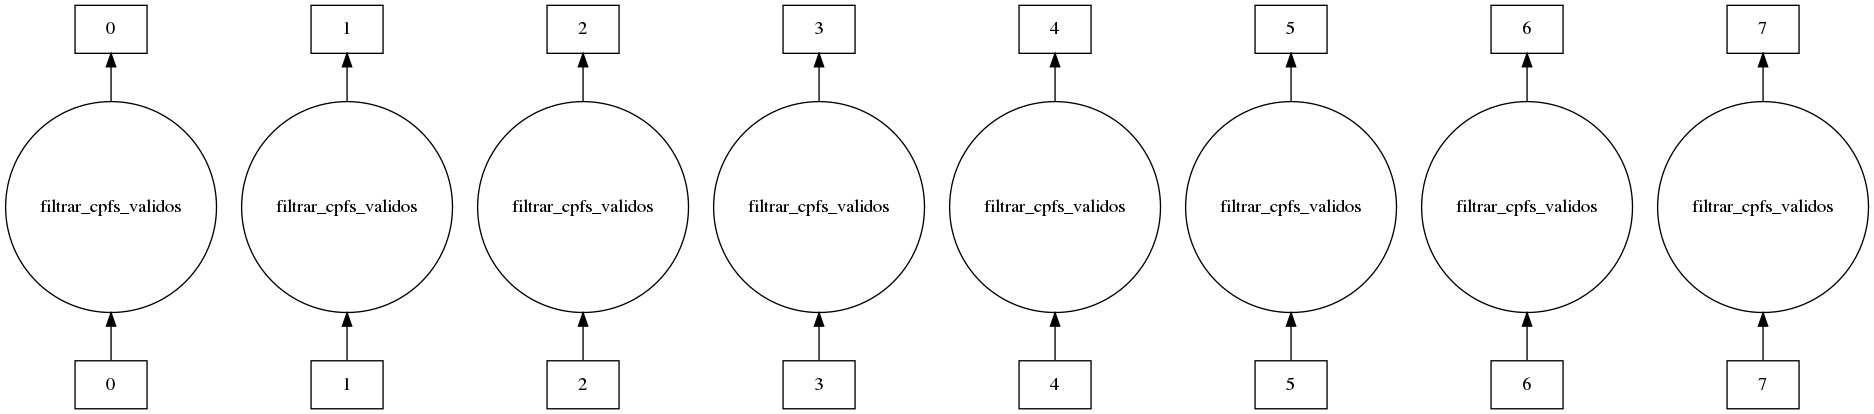

In [36]:
validos.visualize()

In [37]:
%%time
cpfs_validos = validos.compute().astype(np.int64)

CPU times: user 932 ms, sys: 563 ms, total: 1.5 s
Wall time: 26.8 s


## Filtragem com _filter_

In [28]:
# FIXME: não funcionou...

#validos = da.where(vcpf_valido(numeros_distribuidos), numeros_distribuidos, 0)
#validos

## Exibição do resultado

In [38]:
# exibição do resultado
cpfs_validos[:10]

array([ 7395928407, 67890174292, 39542408234, 64972932643, 29879232283,
       20298534452, 40277561426, 91162110228, 15646246172, 21763352609])

In [39]:
print("Do total de %d números da amostra, apenas %d são CPFs válidos (%.2f%%)." % (
    len(numeros_distribuidos), len(cpfs_validos),
    len(cpfs_validos) / len(numeros_distribuidos) * 100))

Do total de 100000000 números da amostra, apenas 1001198 são CPFs válidos (1.00%).


## Finalização do ambiente Dask

In [40]:
client.close()